<a href="https://colab.research.google.com/github/bahadurshubham/bahadurshubham/blob/main/dog_emotion_classify_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing

In [2]:
import numpy as np
import pandas as pd
from keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense,BatchNormalization, Flatten, MaxPool2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
from tensorflow.keras.utils import Sequence
from keras.backend import epsilon
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2

from tqdm.notebook import tqdm_notebook as tqdm

import os

# Data Preprocessing

In [ ]:
print(os.listdir("../input"))

In [ ]:
angry= '../input/dog-emotions-prediction/images/angry/'
sad = '../input/dog-emotions-prediction/images/sad/'
relaxed = '../input/dog-emotions-prediction/images/relaxed/'
happy = '../input/dog-emotions-prediction/images/happy/'


angry_path = os.listdir(angry)
sad_path = os.listdir(sad)
relaxed_path = os.listdir(relaxed)
happy_path = os.listdir(happy)

In [ ]:

def load_img(path):
    image = cv2.imread(path)
    image = cv2.resize(image,(224, 224))
    return image[...,::-1]

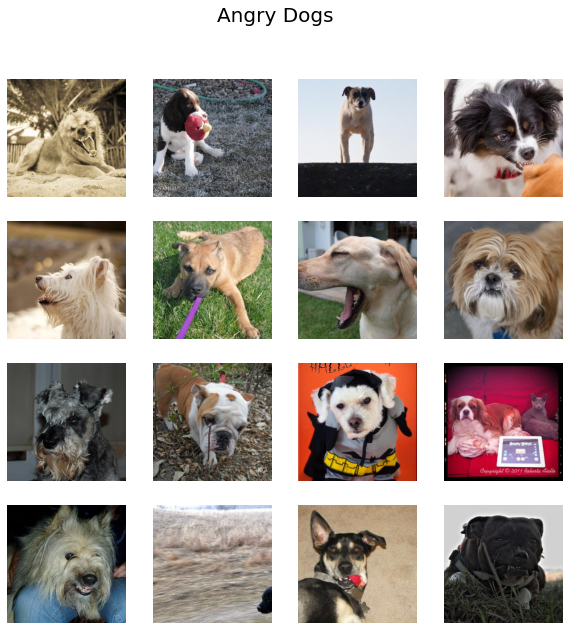

In [ ]:

fig = plt.figure(figsize=(10, 10))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(load_img(angry + angry_path[i]), cmap='gray')
    plt.suptitle("Angry Dogs",fontsize=20)
    plt.axis('off')

plt.show()

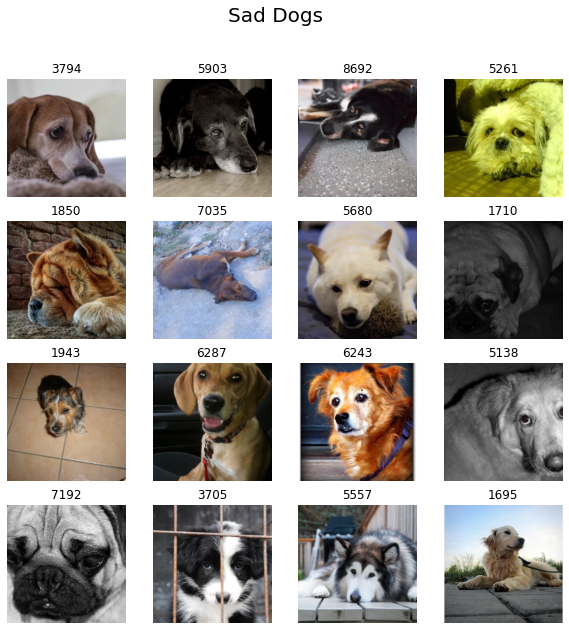

In [ ]:

fig = plt.figure(figsize=(10,10))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(load_img(sad + sad_path[i]), cmap='gray')
    plt.suptitle("Sad Dogs",fontsize=20)
    plt.title(sad_path[i][:4])
    plt.axis('off')

plt.show()

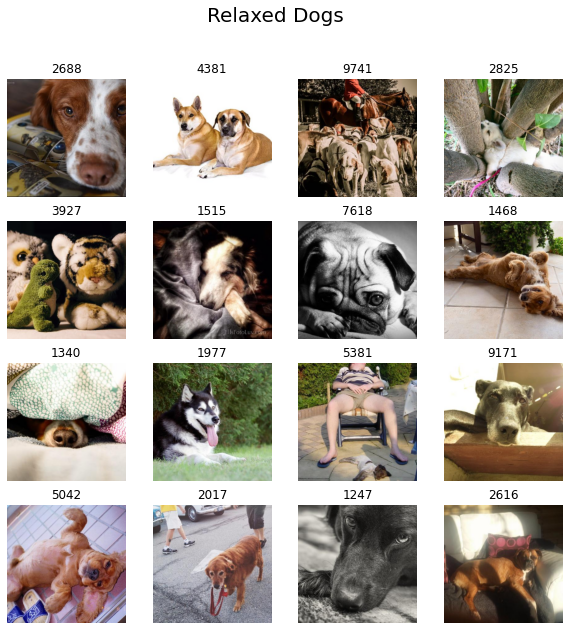

In [ ]:

fig = plt.figure(figsize=(10,10))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(load_img(relaxed + relaxed_path[i]), cmap='gray')
    plt.suptitle("Relaxed Dogs",fontsize=20)
    plt.title(relaxed_path[i][:4])
    plt.axis('off')

plt.show()

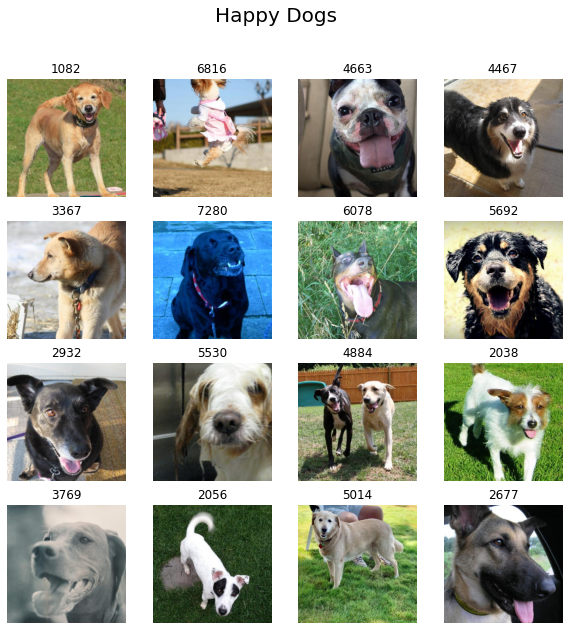

In [ ]:

fig = plt.figure(figsize=(10,10))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(load_img(happy + happy_path[i]), cmap='gray')
    plt.suptitle("Happy Dogs",fontsize=20)
    plt.title(happy_path[i][:4])
    plt.axis('off')

plt.show()

# Modeling

In [ ]:

dataset_path = "/kaggle/input/dog-emotions-prediction/images"

In [ ]:

data_with_aug = ImageDataGenerator(horizontal_flip=True,
                                   vertical_flip=False,
                                   rescale=1./255,
                                  validation_split=0.3)

In [ ]:

train = data_with_aug.flow_from_directory(dataset_path,
                                          class_mode="binary",
                                          target_size=(96, 96),
                                          batch_size=32,
                                          subset="training")

Found 11147 images belonging to 4 classes.


In [ ]:

val = data_with_aug.flow_from_directory(dataset_path,
                                          class_mode="binary",
                                          target_size=(96, 96),
                                          batch_size=32,
                                          subset="validation"
                                          )

Found 4774 images belonging to 4 classes.


# 1) MobileNetV2

In [ ]:

mnet = MobileNetV2(include_top = False, weights = "imagenet" ,input_shape=(96,96,3))

2022-10-23 10:26:05.042156: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-23 10:26:05.136843: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-23 10:26:05.137630: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-23 10:26:05.139195: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:

tf.keras.backend.clear_session()

model = Sequential([mnet,
                    GlobalAveragePooling2D(),
                    Dense(512, activation = "relu"),
                    BatchNormalization(),
                    Dropout(0.3),
                    Dense(128, activation = "relu"),
                    Dropout(0.1),
                    # Dense(32, activation = "relu"),
                    # Dropout(0.3),
                    Dense(4, activation = "sigmoid")])

model.layers[0].trainable = False

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics="accuracy")

model.summary()
Model: "sequential"

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_96 (Functio (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

In [ ]:

def scheduler(epoch):
    if epoch <= 2:
        return 0.001
    elif epoch > 2 and epoch <= 15:
        return 0.0001 
    else:
        return 0.00001

lr_callbacks = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:

hist = model.fit_generator(train,
                    epochs=20,
                    callbacks=[lr_callbacks],
                    validation_data=val)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-10-23 10:26:10.214861: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-10-23 10:26:13.636097: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


349/349 [==============================] - 119s 318ms/step - loss: 1.4038 - accuracy: 0.4261 - val_loss: 1.2510 - val_accuracy: 0.4673
Epoch 2/20
349/349 [==============================] - 50s 144ms/step - loss: 1.1379 - accuracy: 0.5150 - val_loss: 1.2231 - val_accuracy: 0.4732
Epoch 3/20
349/349 [==============================] - 51s 145ms/step - loss: 1.0596 - accuracy: 0.5532 - val_loss: 1.2266 - val_accuracy: 0.4709
Epoch 4/20
349/349 [==============================] - 51s 147ms/step - loss: 0.9307 - accuracy: 0.6191 - val_loss: 1.2025 - val_accuracy: 0.4904
Epoch 5/20
349/349 [==============================] - 52s 149ms/step - loss: 0.8942 - accuracy: 0.6412 - val_loss: 1.2078 - val_accuracy: 0.4914
Epoch 6/20
349/349 [==============================] - 52s 148ms/step - loss: 0.8627 - accuracy: 0.6579 - val_loss: 1.2198 - val_accuracy: 0.4952
Epoch 7/20
349/349 [==============================] - 50s 143ms/step - loss: 0.8351 - accuracy: 0.6735 - val_loss: 1.2356 - val_accuracy: 0.

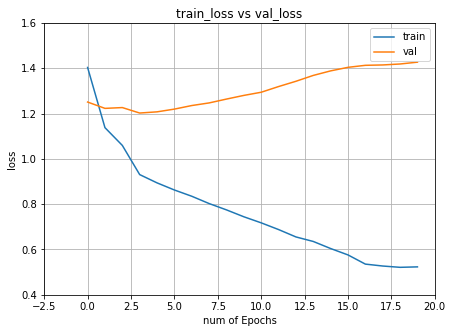

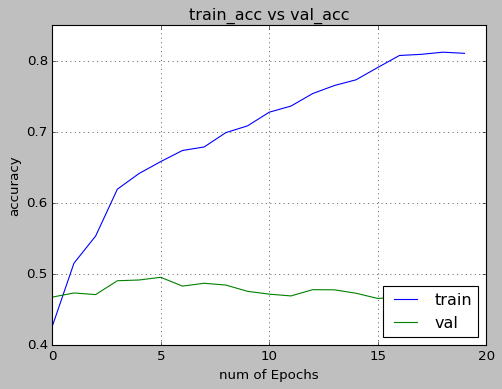

In [ ]:

epochs = 20
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
xc = range(epochs)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

In [ ]:

train = data_with_aug.flow_from_directory(dataset_path,
                                          class_mode="binary",
                                          target_size=(224, 224),
                                          batch_size=98,
                                          subset="training")

val = data_with_aug.flow_from_directory(dataset_path,
                                          class_mode="binary",
                                          target_size=(224, 224),
                                          batch_size=98,
                                          subset="validation"
                                          )

Found 11147 images belonging to 4 classes.
Found 4774 images belonging to 4 classes.


In [ ]:

vgg16_model = tf.keras.applications.vgg16.VGG16(include_top=False, weights="imagenet", input_shape=(224,224,3))

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:

vgg16_model.output[-1]

<KerasTensor: shape=(7, 7, 512) dtype=float32 (created by layer 'tf.__operators__.getitem')>

In [ ]:

# model = Sequential()
# for layer in vgg16_model.layers[:-1]:
#     model.add(layer)

# for layer in model.layers:
#     layer.trainable = False
    
# model.add(Dense(2, activation='softmax'))


model = Sequential([vgg16_model,
                    Flatten(),
#                     GlobalAveragePooling2D(),
#                     Dense(512, activation = "relu"),
#                     BatchNormalization(),
#                     Dropout(0.3),
#                     Dense(128, activation = "relu"),
#                     Dropout(0.1),
#                     # Dense(32, activation = "relu"),
#                     # Dropout(0.3),
                    Dense(4, activation = "sigmoid")])

model.layers[0].trainable = False

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics="accuracy")

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 100356    
Total params: 14,815,044
Trainable params: 100,356
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:

hist =  model.fit_generator(train,
                    epochs=20,
                    callbacks=[lr_callbacks],
                    validation_data=val)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
114/114 [==============================] - 98s 793ms/step - loss: 1.3966 - accuracy: 0.4223 - val_loss: 1.2582 - val_accuracy: 0.4684
Epoch 2/20
114/114 [==============================] - 79s 693ms/step - loss: 1.1645 - accuracy: 0.5169 - val_loss: 1.3320 - val_accuracy: 0.4671
Epoch 3/20
114/114 [==============================] - 80s 702ms/step - loss: 1.0582 - accuracy: 0.5680 - val_loss: 1.2863 - val_accuracy: 0.4669
Epoch 4/20
114/114 [==============================] - 78s 688ms/step - loss: 0.8839 - accuracy: 0.6568 - val_loss: 1.2453 - val_accuracy: 0.4744
Epoch 5/20
114/114 [==============================] - 79s 692ms/step - loss: 0.8589 - accuracy: 0.6736 - val_loss: 1.2403 - val_accuracy: 0.4786
Epoch 6/20
114/114 [==============================] - 79s 690ms/step - loss: 0.8539 - accuracy: 0.6752 - val_loss: 1.2326 - val_accuracy: 0.4799
Epoch 7/20
114/114 [==============================] - 79s 695ms/step - loss: 0.8405 - accuracy: 0.6852 - val_loss: 1.2338 - val_ac

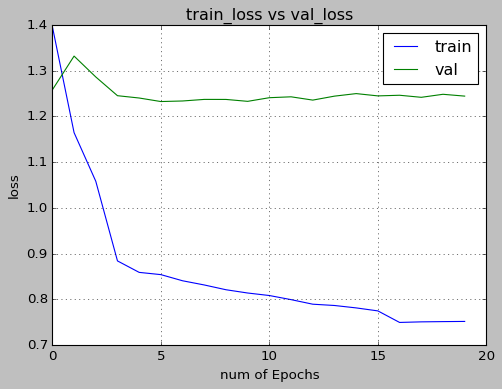

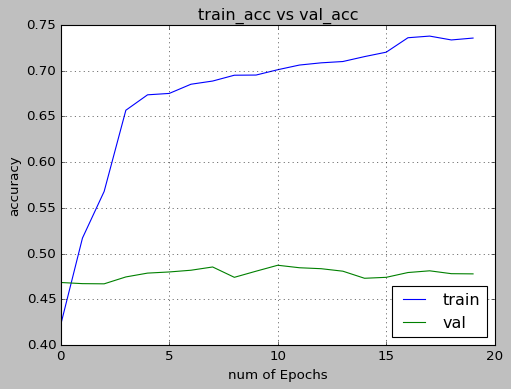

In [ ]:

epochs = 20
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
xc = range(epochs)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

In [ ]:
predictions = model.predict_generator(val)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


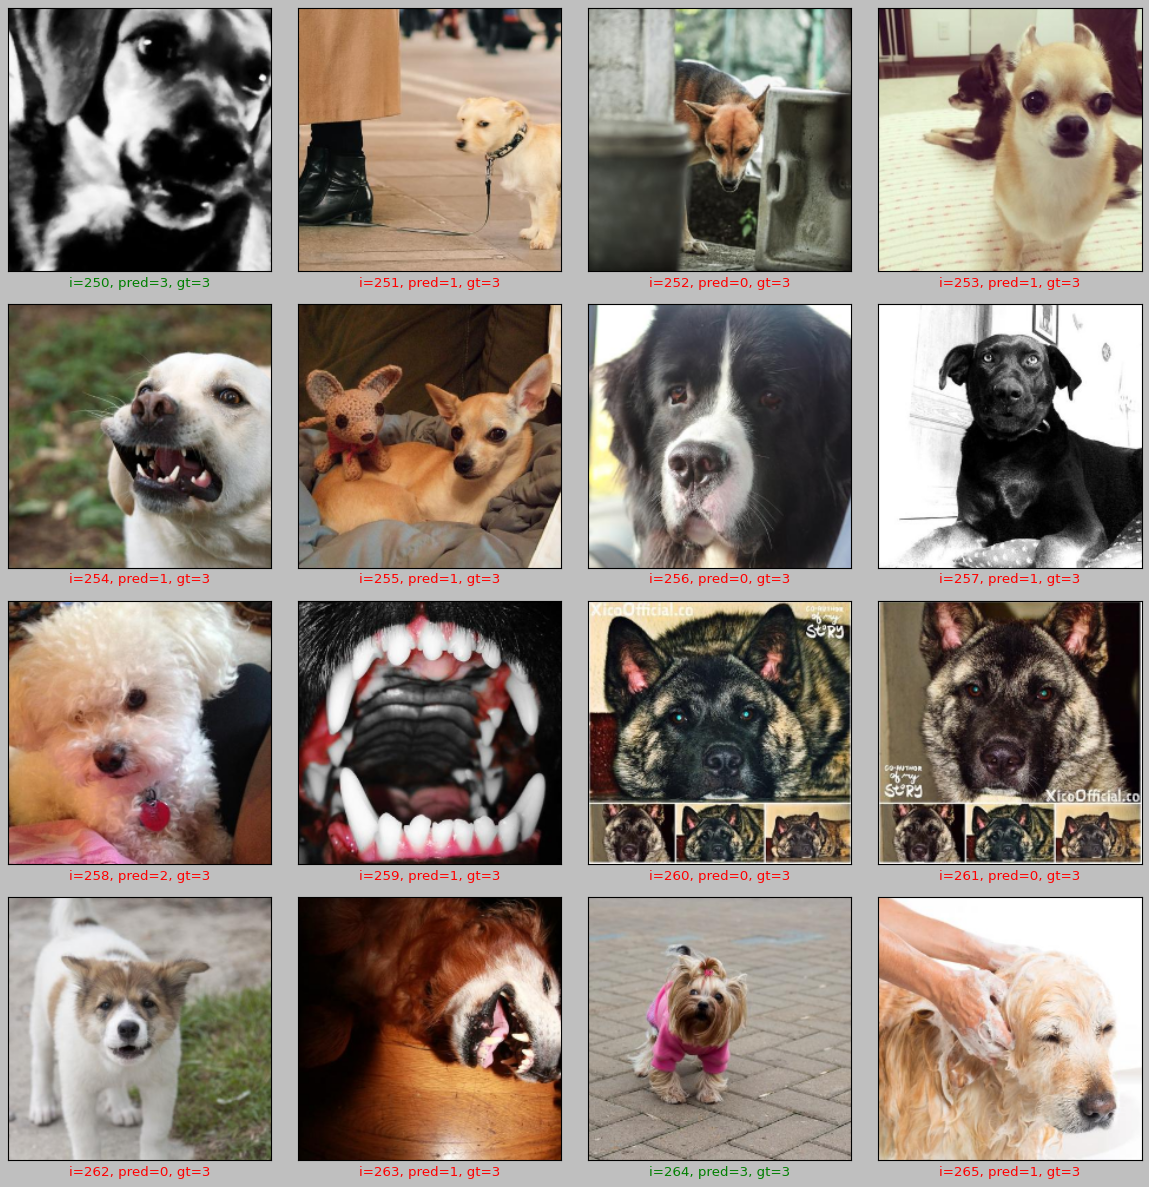

In [ ]:
val_path = "/kaggle/input/dog-emotions-prediction/images/"

plt.figure(figsize=(15,15))

start_index = 250

for i in range(16):
  plt.subplot(4,4, i+1)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  preds = np.argmax(predictions[[start_index+i]])
    
  gt = val.filenames[start_index+i][9:13]

  
  if gt == "angry":
    gt = 0
  elif gt == 'sad':
    gt = 1
  elif gt == 'pleased':
    gt = 2
  else:
    gt = 3
    
  if preds != gt:
    col ="r"
  else:
    col = "g"

  plt.xlabel('i={}, pred={}, gt={}'.format(start_index+i,preds,gt),color=col)
  plt.imshow(load_img(val_path+val.filenames[start_index+i]))
  plt.tight_layout()

plt.show()

Thank you !